# Testing BIBIMBpy

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import agama

agama.setUnits(mass = 1, length = 1, velocity = 1)

In [3]:
import bibimbpy

## create initial conditions

In [54]:
r_ic = 4
phi_ic = 0
z_ic = 0
vz_ic = 0

vr_ic = np.linspace(-100,100,100)
vphi_ic = -np.linspace(-400,-100,100)

In [55]:
ic,var1,var2 = bibimbpy.initialize.set_initial_conditions(r_ic,phi_ic,z_ic,vr_ic,vphi_ic,vz_ic)

In [56]:
ic.shape

(10000, 6)

## Generate axisymmetric potential

In [7]:
pbase = agama.Potential("../../../../Google Drive/My Drive/Recerca/Notebooks/DiscDynamics/Potentials/McMillan17.ini")



## Generate perturbation and its m=0 mode

### generate scaling file

In [8]:
bibimbpy.utils.generate_scaling_file(1,"dehnen",100,"test_scaling_file.txt")

In [9]:
pert_params_dict = {"type":"Ferrers","mass":1e10,"scaleRadius":5,"axisRatioY":0.8,"axisRatioZ":0.2,
                   "scale":"test_scaling_file.txt"}


In [10]:
pot_pertuber = agama.Potential(**pert_params_dict)

scaling_file = pert_params_dict["scale"]

#make the static part
pert_params_dict.pop("scale")
pot_pertuber_static = agama.Potential(**pert_params_dict)
pot_pertuber_m0_static = agama.Potential(type='CylSpline', potential=pot_pertuber_static, 
                                         mmax=0, rmin=0, rmax=20)
pot_pertuber_m0 = agama.Potential(type='CylSpline', potential=pot_pertuber_static, mmax=0, rmin=0, rmax=20, 
                                    scale=bibimbpy.utils.invert_scaling_file(scaling_file))

In [11]:
pbase_m0 = agama.Potential(pbase,pot_pertuber_m0_static)

In [12]:
r_ = np.linspace(0,15,100)
phi_ = np.linspace(0,2*np.pi,100)

R,PHI = np.meshgrid(r_,phi_)

r = R.flatten()
phi = PHI.flatten()

z = np.zeros_like(r)
points = np.column_stack((r*np.cos(phi),r*np.sin(phi),z))
points_line = np.column_stack((r_,r_*0,r_*0))

In [13]:
pm0_stat_eval = pot_pertuber_m0_static.potential(points)

pm0_stat_force = pot_pertuber_m0_static.force(points_line)
pm0_stat_omega = np.sqrt(-pm0_stat_force[:,0]/r_)

pm0_stat_base_force = pbase_m0.force(points_line)
pm0_stat_base_omega = np.sqrt(-pm0_stat_base_force[:,0]/r_)

/var/folders/vj/7jqz0m1j2zs3t7fxnl0d1gfw0000gn/T/ipykernel_29528/4057661711.py:4: RuntimeWarning: invalid value encountered in divide
  pm0_stat_omega = np.sqrt(-pm0_stat_force[:,0]/r_)
/var/folders/vj/7jqz0m1j2zs3t7fxnl0d1gfw0000gn/T/ipykernel_29528/4057661711.py:7: RuntimeWarning: invalid value encountered in divide
  pm0_stat_base_omega = np.sqrt(-pm0_stat_base_force[:,0]/r_)


In [14]:
t0 = 10

In [15]:
pm0_eval = pot_pertuber_m0.potential(points,t=t0)

pm0_force = pot_pertuber_m0.force(points_line,t=t0)
pm0_omega = np.sqrt(-pm0_force[:,0]/r_)

/var/folders/vj/7jqz0m1j2zs3t7fxnl0d1gfw0000gn/T/ipykernel_29528/4203405552.py:4: RuntimeWarning: invalid value encountered in divide
  pm0_omega = np.sqrt(-pm0_force[:,0]/r_)


In [16]:
ppert_eval = pot_pertuber.potential(points,t=t0)

ppert_force = pot_pertuber.force(points_line,t=t0)
ppert_omega = np.sqrt(-ppert_force[:,0]/r_)

/var/folders/vj/7jqz0m1j2zs3t7fxnl0d1gfw0000gn/T/ipykernel_29528/425372579.py:4: RuntimeWarning: invalid value encountered in divide
  ppert_omega = np.sqrt(-ppert_force[:,0]/r_)


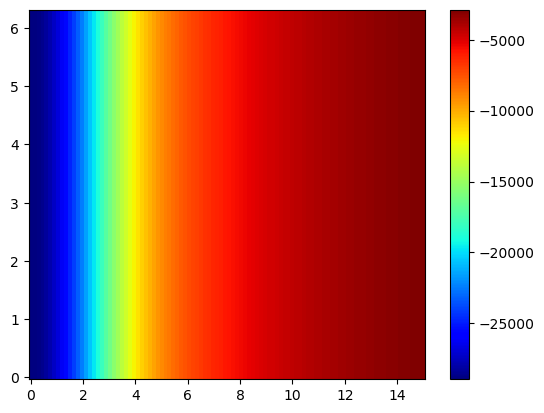

In [17]:
plt.pcolormesh(R,PHI,pm0_stat_eval.reshape(R.shape),cmap="jet")
plt.colorbar();

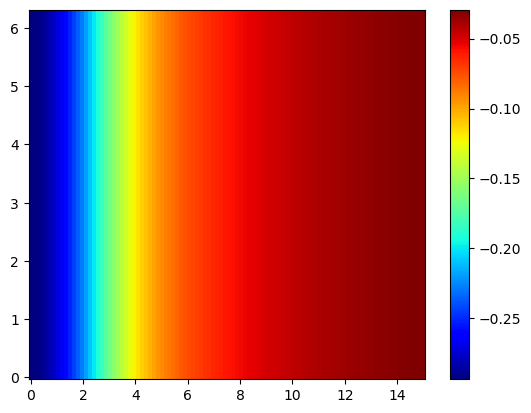

In [18]:
plt.pcolormesh(R,PHI,pm0_eval.reshape(R.shape),cmap="jet")
plt.colorbar();

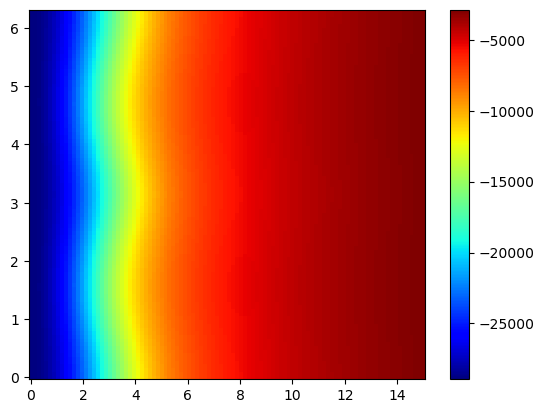

In [19]:
plt.pcolormesh(R,PHI,ppert_eval.reshape(R.shape),cmap="jet")
plt.colorbar()

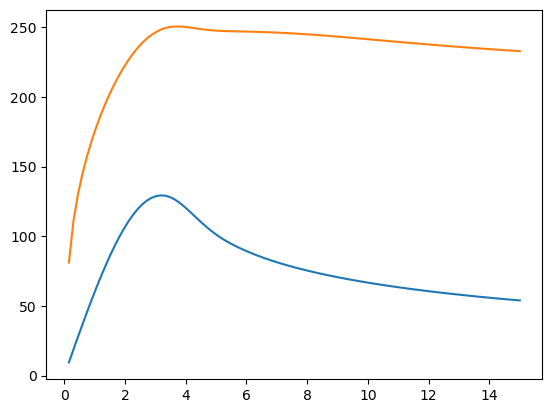

In [20]:
plt.plot(r_,r_*pm0_stat_omega)
plt.plot(r_,r_*pm0_stat_base_omega)

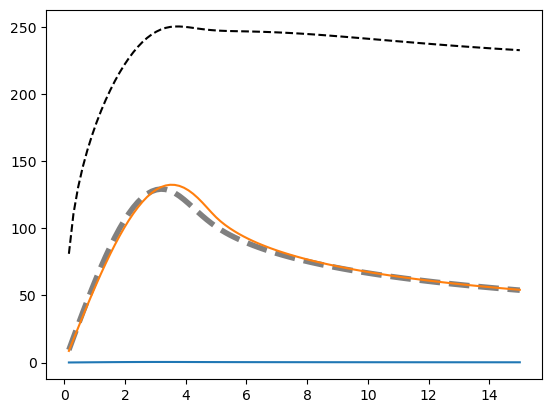

In [21]:
plt.plot(r_,r_*pm0_stat_base_omega,ls="--",color="k")
plt.plot(r_,r_*pm0_stat_omega,ls="--",color="grey",lw=4)
plt.plot(r_,r_*pm0_omega)
plt.plot(r_,r_*ppert_omega)

In [22]:
p_timedep = agama.Potential(pbase,pot_pertuber_m0,pot_pertuber)

In [23]:
t = 10

In [24]:
force = p_timedep.force(points_line,t=t)
omega = np.sqrt(-force[:,0]/r_)

/var/folders/vj/7jqz0m1j2zs3t7fxnl0d1gfw0000gn/T/ipykernel_29528/1185998881.py:2: RuntimeWarning: invalid value encountered in divide
  omega = np.sqrt(-force[:,0]/r_)


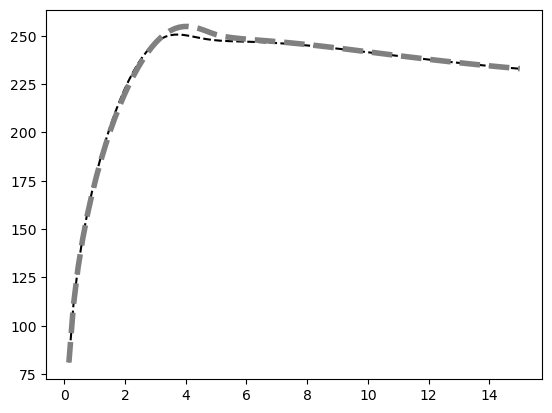

In [25]:
plt.plot(r_,r_*pm0_stat_base_omega,ls="--",color="k")
plt.plot(r_,r_*omega,ls="--",color="grey",lw=4)

## Generate DF

In [26]:
paxisym = agama.Potential(pbase,pot_pertuber_m0_static)

In [27]:
df = agama.DistributionFunction(type="QuasiIsothermal", Sigma0 = 1., Rdisk = 2.5, Hdisk = 0.3, 
                                Rsigmar = 5., sigmar0 = 35./np.exp(-8./5.), potential = paxisym)

## Run BI

In [28]:
pattern_speed = 60

In [51]:
force = paxisym.force(points_line)
omega = np.sqrt(-force[:,0]/r_)

/var/folders/vj/7jqz0m1j2zs3t7fxnl0d1gfw0000gn/T/ipykernel_29528/1345282527.py:2: RuntimeWarning: invalid value encountered in divide
  omega = np.sqrt(-force[:,0]/r_)


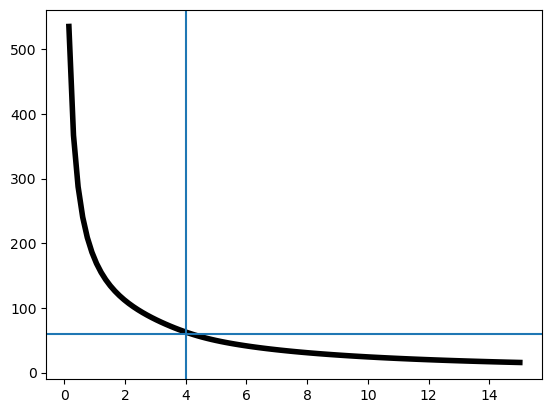

In [53]:
plt.plot(r_,omega,color="k",lw=4)
plt.axhline(pattern_speed)
plt.axvline(4)

In [29]:
Tb = np.abs(2*np.pi/pattern_speed)
print(Tb)

0.10471975511965977


In [70]:
30*Tb

3.141592653589793

In [71]:
df_eval = bibimbpy.orbits.runBI(ic,p_timedep,paxisym,df,Tb,30,pattern_speed)

10000 orbits complete (1e+04 orbits/s)


In [72]:
df_sum,vre,vphie = bibimbpy.utils.DFhistogram2d(var1,var2,df_eval,100)

In [73]:
df_sum.shape

(100, 100)

In [74]:
vre.shape

(101,)

In [75]:
VR,VPHI = np.meshgrid(0.5*(vre[1:]+vre[:-1]),0.5*(vphie[1:]+vphie[:-1]))

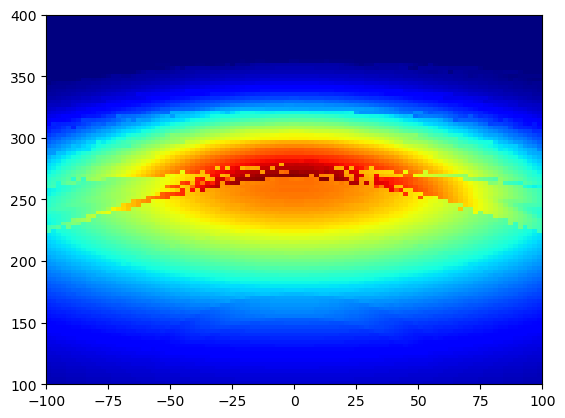

In [76]:
plt.pcolormesh(VR,VPHI,df_sum.T,cmap="jet")

In [36]:
af = agama.ActionFinder(paxisym)

In [37]:
ic

array([[   8.        ,    0.        ,    0.        , -100.        ,
         400.        ,    0.        ],
       [   8.        ,    0.        ,    0.        , -100.        ,
         396.96969697,    0.        ],
       [   8.        ,    0.        ,    0.        , -100.        ,
         393.93939394,    0.        ],
       ...,
       [   8.        ,    0.        ,    0.        ,  100.        ,
         106.06060606,    0.        ],
       [   8.        ,    0.        ,    0.        ,  100.        ,
         103.03030303,    0.        ],
       [   8.        ,    0.        ,    0.        ,  100.        ,
         100.        ,    0.        ]])

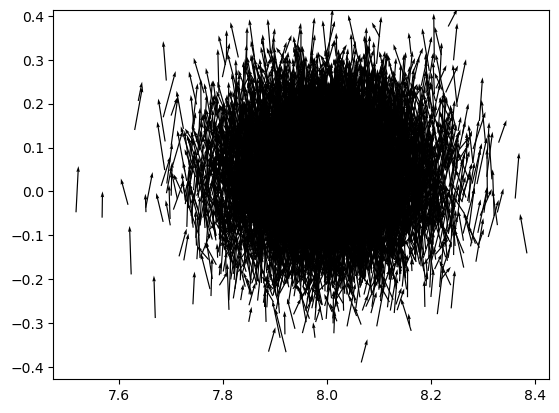

In [38]:
plt.quiver(ic[:,0]+np.random.normal(scale=0.1,size=ic.shape[0]),
           ic[:,1]+np.random.normal(scale=0.1,size=ic.shape[0]),
           ic[:,3],ic[:,4],scale=4000)
#plt.xlim(7.99,8.01)